# Replay buffer for MNIST classification

In [1]:
import os
import jax
import optax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
from tqdm.notebook import tqdm
from typing import Callable, Tuple
from flax.training.train_state import TrainState

In [10]:
from rebayes.utils import rotating_mnist_data
from rebayes.sgd_filter import replay_sgd, sgd

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%config InlineBackend.figure_format = "retina"

# (Sorted) rotated MNIST

In [15]:
train, test = rotating_mnist_data.load_rotated_mnist(target_digit=2, sort_by_angle=True)

(X, y) = train
(X_test, y_test) = test

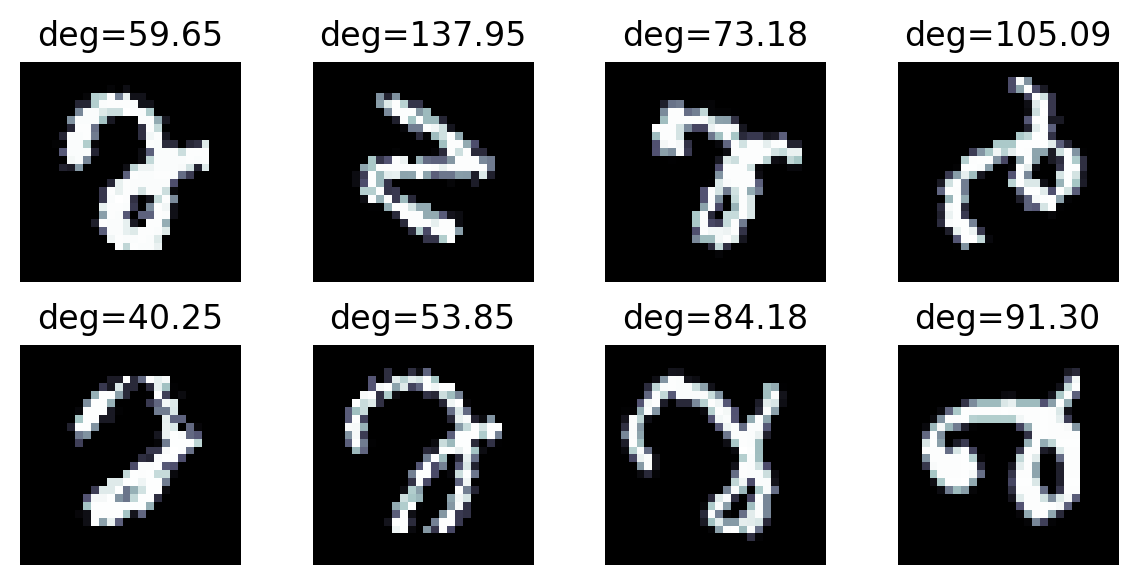

In [16]:
np.random.seed(314)
n_test = 8
ixs_test = np.random.randint(0, len(X), size=n_test)

fig, axs = plt.subplots(2, 4, figsize=(6, 3))
axs = axs.ravel()
for ax, ix in zip(axs, ixs_test):
    img = X[ix]
    deg = y[ix]
    ax.imshow(img.reshape(28, 28), cmap="bone")
    ax.axis("off")
    ax.set_title(f"{deg=:0.2f}")
plt.tight_layout()

# Training

## Setup

In [17]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x

In [18]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

## Vanilla SGD

In [19]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn(params, X, y, applyfn):
    yhat = applyfn(params, X)
    nll = (y - yhat.ravel()) ** 2
    return nll.mean()


@partial(jax.jit, static_argnames=("applyfn",))
def metric(params, X, y, applyfn):
    yhat = applyfn(params, X)
    err = jnp.abs(y - yhat.ravel())
    return err.mean()

In [20]:
%%time
dim_out = 1
num_epochs = 5_000
batch_size = 1000

model = MLP(dim_out, activation=nn.elu)
batch_init = jnp.ones((1, 28 ** 2))
params_init = model.init(key_init, batch_init)

state = TrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(5e-5),
)


state, losses = sgd.train_full(
    key_init, num_epochs, batch_size, state, X, y, lossfn,
    X_test, y_test
)
losses = jax.block_until_ready(losses)

CPU times: user 15.3 s, sys: 330 ms, total: 15.6 s
Wall time: 11.9 s


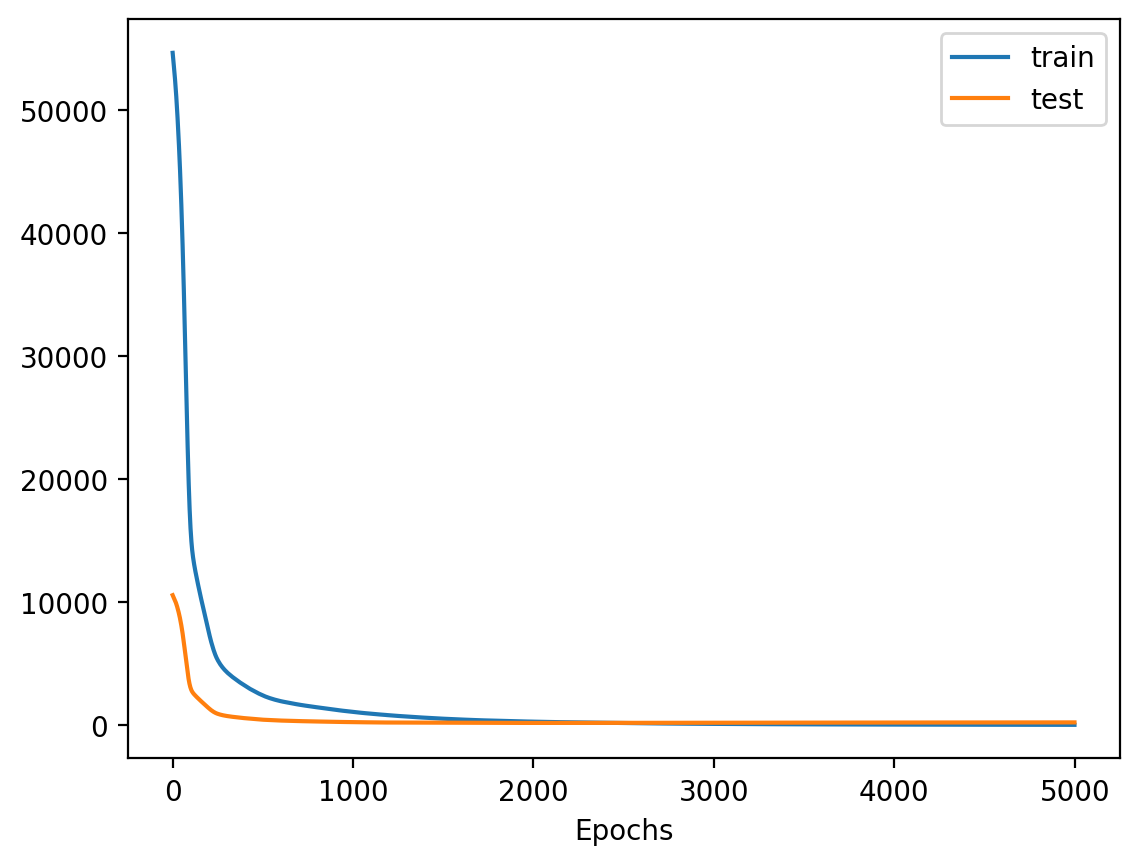

In [21]:
plt.plot(losses["train"], label="train")
plt.plot(losses["test"], label="test")
plt.legend()
plt.xlabel("Epochs");

In [22]:
sgd_loss = metric(state.params, X_test, y_test, state.apply_fn).item()
sgd_loss

10.143590927124023

# Replay buffer FIFO

Consider a buffer with size 4, the minibatches are given by
```
[x0,]
[x0, x1]
[x0, x1, x2]
[x0, x1, x2, x3]
[x1, x2, x3, x4]
[x2, x3, x4, x5]
...
```

In [23]:
@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_fifo(params, counter, X, y, applyfn):
    yhat = applyfn(params, X).ravel()
    loss = (y - yhat) ** 2
    loss = (loss * counter).sum() / counter.sum()
    return loss

In [24]:
model = MLP(dim_out, activation=nn.elu)
batch_init = jnp.ones((dim_out, 28 ** 2))
params_init = model.init(key_init, batch_init)

In [25]:
learning_rate = 5e-5

In [29]:
%%time
dim_features = 28 ** 2

buffer_size = 100
n_inner = 2


tx = optax.adam(learning_rate)
rebayes = replay_sgd.FifoSGD(
    lossfn_fifo,
    model.apply,
    params_init,
    tx,
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=dim_out,
    n_inner=n_inner
)

def rmae_test(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    
    yhat = model.apply(bel.params, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean()
    }
    return res


test = {"X_test": X_test, "y_test": y_test}
state, losses = rebayes.scan(X, y, callback=rmae_test, **test)
acc = rmae_test(state, X_test=X_test, y_test=y_test)["test"]
acc = jax.block_until_ready(acc)
acc

CPU times: user 3.91 s, sys: 101 ms, total: 4.01 s
Wall time: 2.86 s


Array(88.971405, dtype=float32)

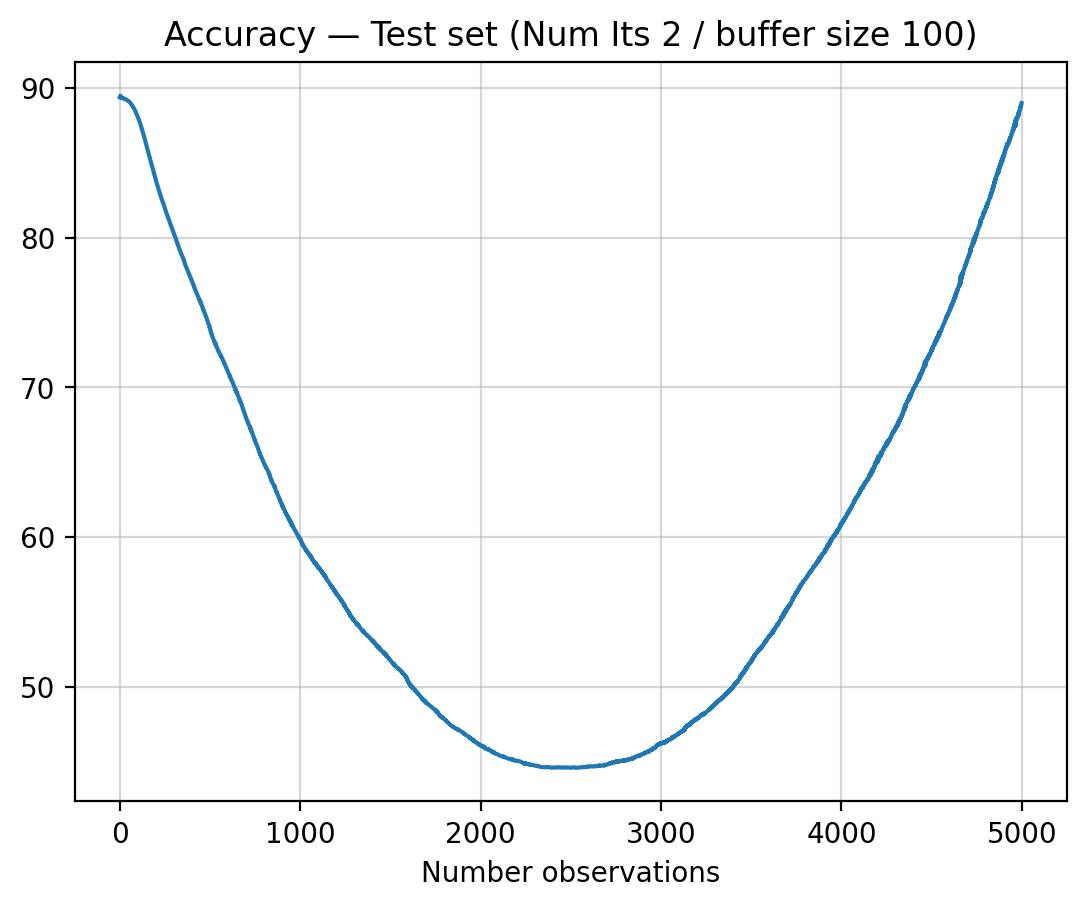

In [30]:
plt.plot(losses["test"])
plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

In [ ]:
%%time
n_inner = 1
buffer_size = 100

@partial(jax.pmap, in_axes=0)
@partial(jax.vmap, in_axes=1)
def init_and_train(key):
    params_init = model.init(key, batch_init)
    
    agent = deepcopy(rebayes)
    agent.n_inner = n_inner
    agent.params = params_init
    
    state, losses = agent.scan(X, y, callback=rmae_test, progress_bar=False, **test)
    return state, losses
    

n_samples = 8 * 5
keys = jax.random.split(key, n_samples).reshape(8, 2, -1)
states, losses = init_and_train(keys)
losses = jax.block_until_ready(losses)

CPU times: user 9.16 s, sys: 142 ms, total: 9.3 s
Wall time: 7.04 s


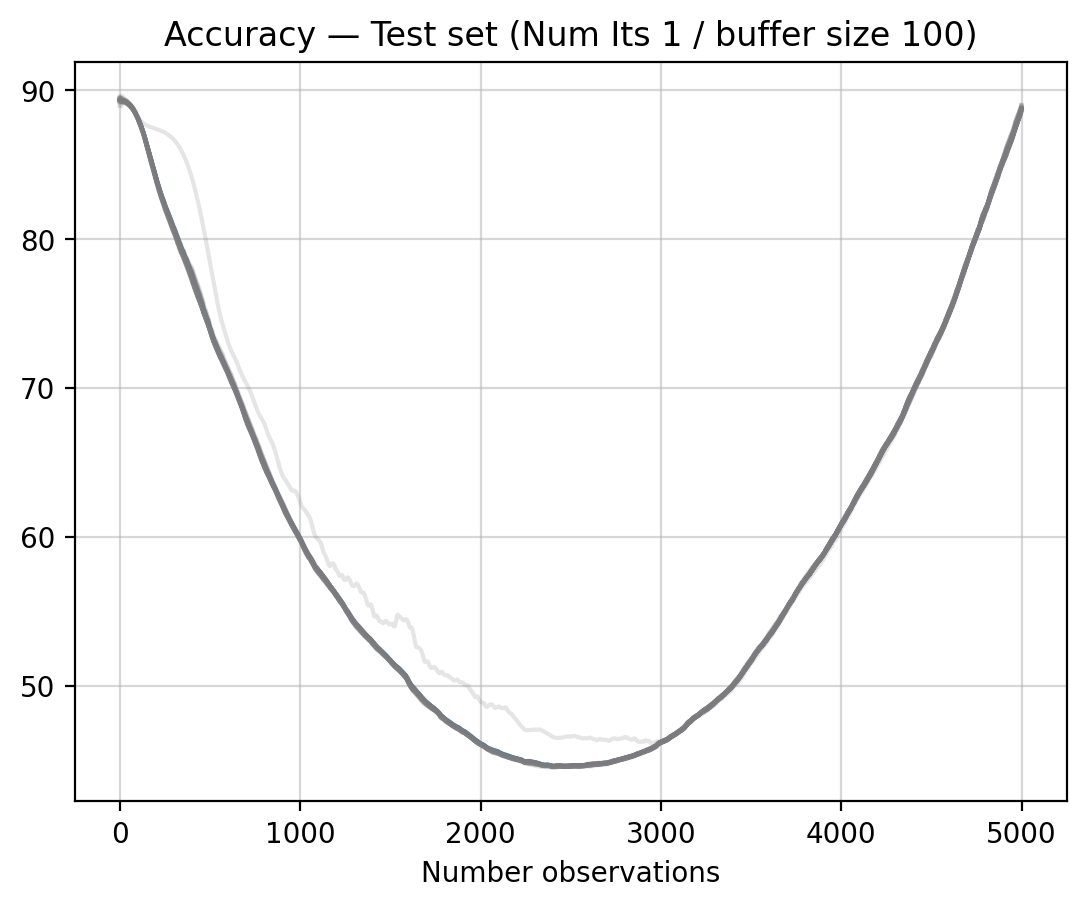

In [ ]:
xrange = jnp.ones_like(y).cumsum()
losses_test = losses["test"].reshape(n_samples, -1)
mean_loss = losses_test.mean(axis=0)
std_loss = losses_test.std(axis=0)
plt.plot(xrange, mean_loss)
# plt.fill_between(xrange, mean_loss - 2 * std_loss, mean_loss + 2 * std_loss, alpha=0.3)

for ltest in losses_test:
    plt.plot(ltest, c="tab:gray", alpha=0.2)

plt.grid(alpha=0.5)
plt.xlabel("Number observations")
plt.title(f"Accuracy — Test set (Num Its {n_inner} / buffer size {buffer_size})");

### Multiple buffer sizes

In [64]:
%%time
buffer_size_list = [1, 5, 10, 20, 50, 100, 200, 300]
n_buffers = len(buffer_size_list)

n_inner = 2
test_losses = {}


state_init = replay_sgd.FifoTrainState.create(
    apply_fn=model.apply,
    params=params_init,
    tx=optax.adam(learning_rate),
    buffer_size=buffer_size,
    dim_features=dim_features,
    dim_output=dim_out,
)


for buffer_size in (pbar := tqdm(buffer_size_list)):
    
    state_init_test = state_init.replace(buffer_size=buffer_size)
    
    rebayes = replay_sgd.FifoSGD(lossfn_fifo, n_inner=n_inner)
    state, losses = rebayes.scan(X, y, bel=state_init_test, callback=rmae_test, progress_bar=False, **test)
    test_losses[buffer_size] = losses["test"]
    acc = losses["test"][-1]
    pbar.set_description(f"acc-{buffer_size:03}={acc:0.4f}")

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 31.7 s, sys: 480 ms, total: 32.2 s
Wall time: 24.1 s


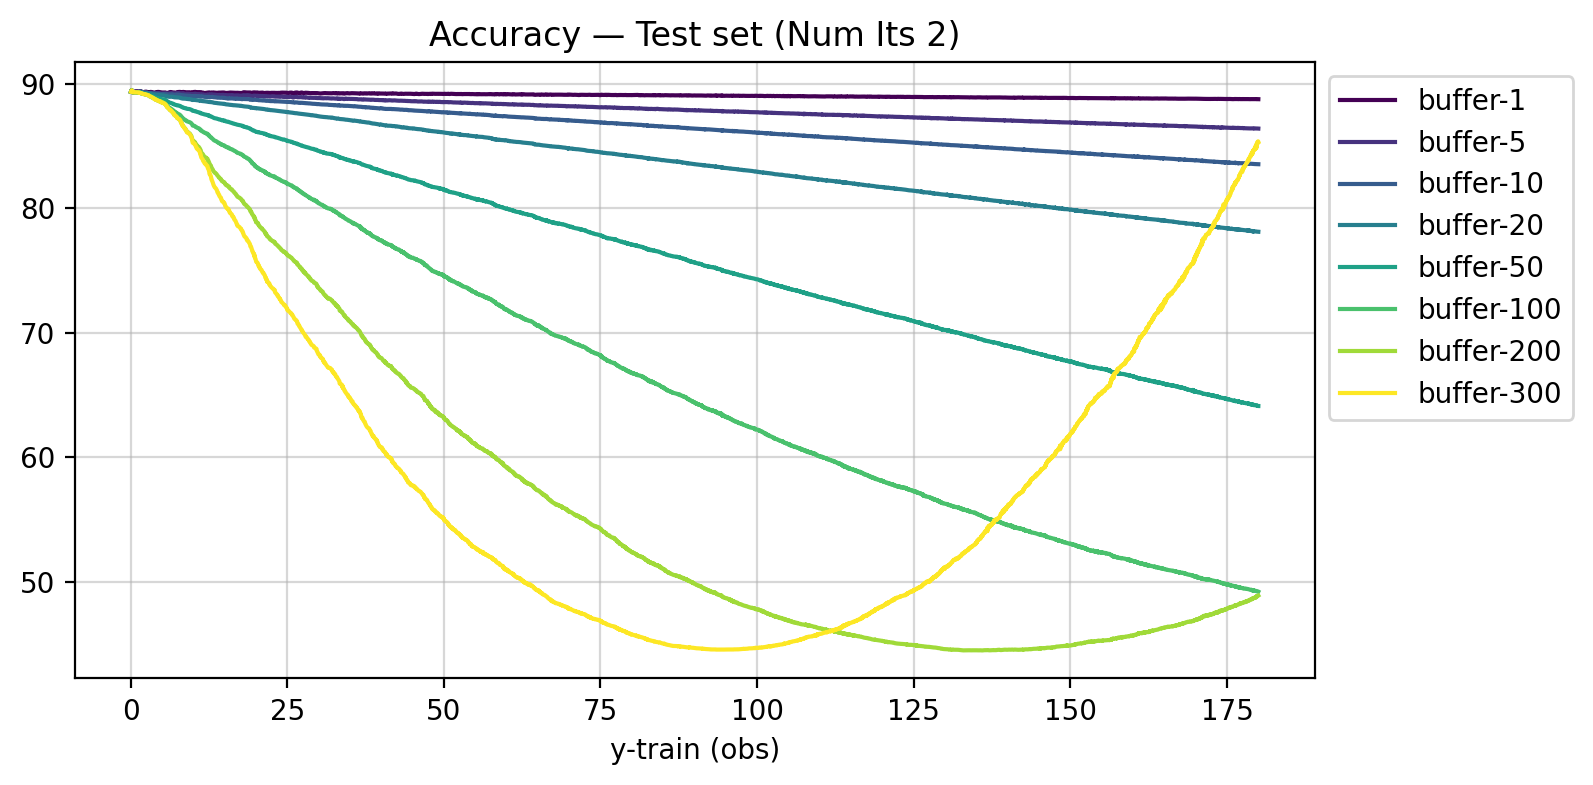

In [65]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.viridis(np.linspace(0, 1, n_buffers))

for c, buffer_size in zip(colors, buffer_size_list):
    loss_test = test_losses[buffer_size]
    plt.plot(y, loss_test, c=c, label=f"buffer-{buffer_size}")
    
plt.xlabel("y-train (obs)")
plt.title(f"Accuracy — Test set (Num Its {n_inner})")
# plt.axhline(y=sgd_loss, c="tab:gray", linestyle="--", label="SGD minibatch")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.grid(alpha=0.5)